In [1]:
from os import chdir
chdir('..')

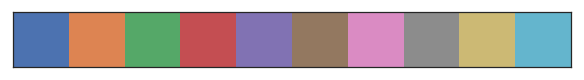

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import math
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from polylidar import extractPlanesAndPolygons
from shapely.geometry import LineString, asPolygon
from shapely.affinity import scale
from os import path
from concave_evaluation.helpers import fake_building, plot_line, BLUE, GRAY, plot_arrow, scale_axes, plot_poly, load_polygon, get_max_bounds_polys
%matplotlib inline
sns.set(font_scale=2)  # crazy big
sns.set_style("white")
current_palette = sns.color_palette()
sns.palplot(current_palette)


In [3]:
def simple(xmin, ymin, xmax, ymax):
    return [xmin, xmax], [ymin, ymax]


def scale_axes_poly_(points):
    maxs = points.max(axis=0)
    mins = points.min(axis=0)
    return [mins[0], maxs[0]], [mins[1], maxs[1]]

def plot_gt(poly):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    plot_poly(poly, ax, plot_holes=True)
    scale_axes(*simple(*get_max_bounds_polys([miholes])), ax)
    plt.axis('off')
    ax.axis('equal')
    return fig

In [4]:
num_points = 2000
FIXTURES = "test_fixtures"
GEN_POLYS_FILE = path.join(FIXTURES,"generated", "polygons.pkl")

gen_polys, poly_params = pickle.load(open(GEN_POLYS_FILE, 'rb'))
df = pd.DataFrame.from_records(poly_params)
df.head()

,convexity,nv,pi,pr,ps,r
0,0.815492,100,0.1,100,0.1,0
1,0.799573,100,0.1,100,0.1,1
2,0.814719,100,0.1,100,0.1,2
3,0.817231,100,0.1,100,0.1,3
4,0.762802,100,0.1,100,0.1,4


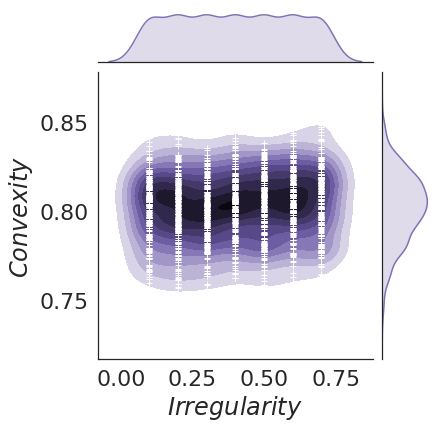

In [5]:
df_pi = df[df.ps == 0.1]
g = sns.jointplot(x="pi", y="convexity", data=df_pi, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Irregularity$", "$Convexity$");

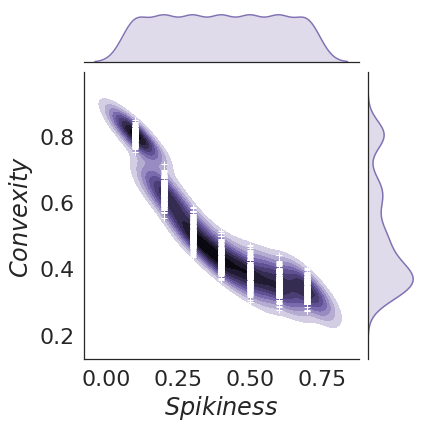

In [6]:
df_ps = df[df.pi == 0.1]
g = sns.jointplot(x="ps", y="convexity", data=df_ps, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Spikiness$", "$Convexity$");

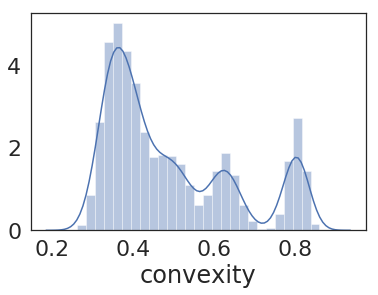

In [7]:
sns.distplot(df['convexity'])

# Polylidar Accuracy and Timings

         alg  convexity  holes  is_valid   l2_norm  points  \
0  polylidar   0.815492  False      True  0.070596    2000   
1  polylidar   0.799573  False      True  0.074861    2000   
2  polylidar   0.814719  False      True  0.080359    2000   
3  polylidar   0.817231  False      True  0.078682    2000   
4  polylidar   0.762802  False      True  0.086809    2000   

                                          poly_param section   time  
0  {'nv': 100, 'pr': 100, 'pi': 0.1, 'ps': 0.1, '...     all  2.256  
1  {'nv': 100, 'pr': 100, 'pi': 0.1, 'ps': 0.1, '...     all  2.025  
2  {'nv': 100, 'pr': 100, 'pi': 0.1, 'ps': 0.1, '...     all  1.954  
3  {'nv': 100, 'pr': 100, 'pi': 0.1, 'ps': 0.1, '...     all  2.063  
4  {'nv': 100, 'pr': 100, 'pi': 0.1, 'ps': 0.1, '...     all  1.920  
0.2615108232789212


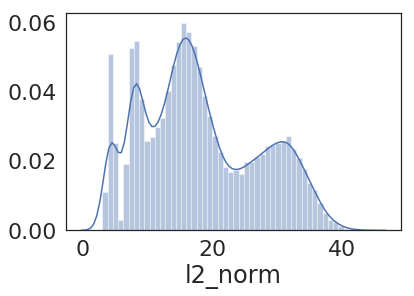

In [8]:
df = pd.read_csv(path.join(FIXTURES, "results", "polylidar_montecarlo.csv"))
print(df.head())
df['l2_norm'] = df['l2_norm'] * 100
sns.distplot(df['l2_norm'])
print(df['convexity'].min())

In [9]:
# These numbers are chosen arbitrarily
# Looking at the distribuiton I generated way to many complex polygons
convexity_vh = 0.85
convexity_hi = 0.70
convexity_mid = 0.55
def get_catergory(x):
    if x >= convexity_vh:
        return 'very hi'
    elif x >= convexity_hi:
        return "hi"
    elif x >= convexity_mid:
        return "mid"
    return "low"

df['$C$'] = df['convexity'].map(get_catergory)
df_result = df.groupby(['$C$', 'points']).agg(
    {'l2_norm':['mean','std', 'max'],'time':['mean', 'std', 'max']})
df_result= df_result.rename(columns={"l2_norm": "$L^2\%$", "time": "time (ms)"})
df_result = df_result.reindex(['very hi','hi', 'mid', 'low'], level='$C$')
print(df_result.to_latex(escape=False, float_format="%.1f"))
df_result

\begin{tabular}{llrrrrrr}
\toprule
    &      & \multicolumn{3}{l}{$L^2\%$} & \multicolumn{3}{l}{time (ms)} \\
    &      &    mean & std &  max &      mean & std &  max \\
$C$ & points &         &     &      &           &     &      \\
\midrule
very hi & 2000 &     7.4 & 1.0 &  8.5 &       1.9 & 0.0 &  2.0 \\
    & 8000 &     3.9 & 0.4 &  4.4 &       8.3 & 0.2 &  8.5 \\
hi & 2000 &     8.5 & 1.1 & 14.7 &       2.0 & 0.1 &  3.3 \\
    & 8000 &     4.5 & 0.5 &  7.3 &       8.3 & 0.4 & 15.2 \\
mid & 2000 &    15.4 & 1.9 & 23.7 &       2.0 & 0.1 &  4.9 \\
    & 8000 &     8.2 & 1.0 & 13.0 &       8.4 & 0.4 & 13.8 \\
low & 2000 &    28.4 & 5.1 & 43.6 &       2.0 & 0.1 &  3.5 \\
    & 8000 &    15.5 & 2.9 & 25.0 &       8.5 & 0.4 & 17.2 \\
\bottomrule
\end{tabular}



$L^2\%$                      time (ms)                  
                     mean       std        max      mean       std     max
$C$     points                                                            
very hi 2000     7.442829  0.959100   8.515837  1.928875  0.031092   1.965
        8000     3.910486  0.383843   4.373968  8.268125  0.158329   8.515
hi      2000     8.469256  1.060580  14.691181  1.953464  0.093093   3.274
        8000     4.456740  0.504795   7.261342  8.337628  0.421371  15.230
mid     2000    15.447039  1.924981  23.746601  1.980356  0.131692   4.897
        8000     8.190407  1.031305  13.035503  8.412482  0.424908  13.787
low     2000    28.387877  5.056390  43.558420  2.019897  0.092678   3.487
        8000    15.541077  2.937822  25.037691  8.543874  0.418255  17.192

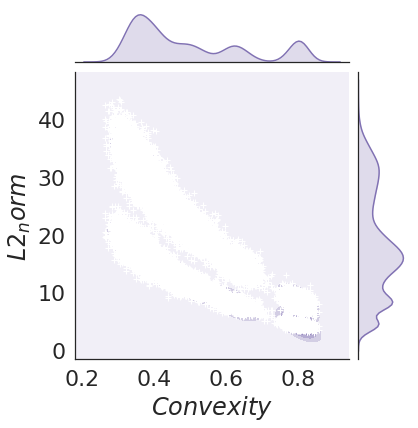

In [10]:
g = sns.jointplot(x="convexity", y="l2_norm", data=df, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
# g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Convexity$", "$L2_norm$");

# Visualize Generated Polygons

In [11]:
polygon_fpath = "test_fixtures/generated/polygons_holes.pkl"
poly_list, poly_params = pickle.load(open(polygon_fpath, 'rb'))
df = pd.DataFrame.from_records(poly_params)
lc_index = df[df.convexity == df['convexity'].min()].index.values[0]
lc_convexity = df[df.convexity == df['convexity'].min()].values[0][0]
vh_index = df[df.convexity == df['convexity'].max()].index.values[0]
vh_convexity = df[df.convexity == df['convexity'].max()].values[0][0]

lc_poly = poly_list[lc_index]
vh_holy = poly_list[vh_index]

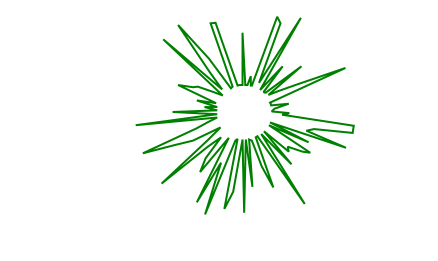

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_poly(lc_poly, ax, plot_holes=False)
scale_axes(*simple(*get_max_bounds_polys([lc_poly])), ax)
plt.axis('off')
ax.axis('equal')
fig.savefig("./assets/pics/low_convexity.pdf",bbox_inches='tight')

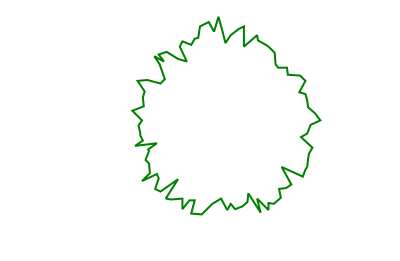

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_poly(vh_holy, ax, plot_holes=False)
scale_axes(*simple(*get_max_bounds_polys([vh_holy])), ax)
plt.axis('off')
ax.axis('equal')
fig.savefig("./assets/pics/hi_convexity.pdf",bbox_inches='tight')

In [14]:
print(f"LC Poly: {lc_convexity*100:.1f}; HC Poly: {vh_convexity*100:.1f}")

LC Poly: 26.2; HC Poly: 86.1
